In [1]:
import numpy  as np
import pandas as pd
from scipy.sparse import load_npz

train_x_path='train_x.npz'
train_y_path='train_y_encoded.npz'
test_x_path='test_x.npz'

print 'load in training set...'
train_x=np.array(load_npz(train_x_path).todense())
train_y = np.array(load_npz(train_y_path).todense())

#put random seed here
selected_sample_index=np.random.choice(int(train_x.shape[0]),1000,replace=False)
train_x=train_x[selected_sample_index,]
train_y=train_y[selected_sample_index,]

print 'train_x:',train_x.shape
print 'train_y:',train_y.shape


def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def loss(y,nn_output):
    return 0.5*(sum(np.array(y)-np.array(nn_output))**2)

class NN(object):
    def __init__(self, num_neuron_per_layer,lr=0.01,batch=1,epoch=20):
        self.lr=lr
        self.batch=batch
        self.epoch=epoch
        self.num_layers = len(num_neuron_per_layer)
        self.num_neuron_per_layer = num_neuron_per_layer#dummy neuron for the bias ignored
        self.reset_weights_bias()

    def reset_weights_bias(self):
        self.weights=[]
        self.bias=[]
        for i in range(0,self.num_layers-1):
            weight=np.random.randn(self.num_neuron_per_layer[i], self.num_neuron_per_layer[i+1])
            self.weights.append(weight)
            self.bias.append(np.random.randn(self.num_neuron_per_layer[i+1]))

    #per sample
    def feedforward(self, nn_input):
        layer_output_his=[]
        layer_output_his.append(nn_input)#to facilitate sgd, add the 0-layer input
        layer_input=np.array(nn_input)
        #layer_input.reshape(-1,1)
        for w,b in zip(self.weights,self.bias):
            layer_output = sigmoid(np.dot(w.T, layer_input)+b[0])
            layer_output_his.append(layer_output)
            layer_input=layer_output
        return layer_output_his #layer_output_his[-1] is nn_output
    
    def gradient_descent(self,true_y,layer_output_his):
        delta_weights=[]
        delta_bs=[]
        layer_output=layer_output_his[-1]
        sig=np.dot(layer_output,np.ones(len(layer_output))-layer_output)
        delta_base=np.dot(true_y-layer_output,sig)
        layer_output_his=layer_output_his[:-1]
        for w,layer_output in zip(reversed(self.weights),reversed(layer_output_his)):
            delta_weight=-np.outer(layer_output,delta_base)
            delta_weights.append(delta_weight)
            delta_b=-delta_base
            delta_bs.append(delta_b)
            sig=np.dot(layer_output,np.ones(len(layer_output))-layer_output)
            delta_base=-np.dot(w,np.multiply(sig,delta_base))
        
        return delta_weights,delta_bs
    
    def batch_gradient_descent(self, input_x,input_y):
        while input_x.shape[0]>self.batch:
            current_batch_index=np.random.choice(int(input_x.shape[0]),self.batch,replace=False)
            batch_x=input_x[current_batch_index,]
            batch_y=input_y[current_batch_index,]
            input_x=np.delete(input_x, current_batch_index, axis=0)
            input_y=np.delete(input_y, current_batch_index, axis=0)
            acc_weights=0
            acc_bias=0
            for x,y in zip(batch_x,batch_y):
                layer_output_his=self.feedforward(x)
                delta_weights,delta_bs=self.gradient_descent(y,layer_output_his)
                acc_weights=np.add(acc_weights,delta_weights)
                acc_bias=np.add(acc_bias,delta_bs)
            self.update_model(acc_weights,acc_bias)
        if input_x.shape[0]>0:
            for x,y in zip(input_x,input_y):
                layer_output_his=self.feedforward(x)
                delta_weights,delta_bs=self.gradient_descent(y,layer_output_his)
                acc_weights=np.add(acc_weights,delta_weights)
                acc_bias=np.add(acc_bias,delta_bs)
            self.update_model(acc_weights,acc_bias)
        
        c_loss=0
        for x,y in zip(input_x,input_y):
            c_loss+=loss(y,self.feedforward(x)[-1])
        print 'loss after this epoch = ',c_loss
        
    
    def update_model(self,delta_weights,delta_bs):
        for i in range(0,self.num_layers-1):
            self.weights[i]=np.add(self.weights[i],np.multiply(delta_weights[-(i+1)],self.lr))
            self.bias[i]=np.add(self.bias[i],np.multiply(delta_bs[-(i+1)],self.lr))
    
    def split_dataset(self,input_x,input_y,num_folder=3):
        if len(input_x)!=len(input_y):
            print 'len(input_x) = ',len(input_x),'; len(input_y) = ',len(input_y)
            print 'len(input_x) must be equal to len(input_y).'
            return None
        return (np.linspace(0,len(input_y),num_folder+1,endpoint=True)).astype(int).tolist()[1:]
        
        
    def fit_model(self,input_x,input_y,cv=False):
        if cv:
            split_index_end=self.split_dataset(input_x,input_y)
            mse_his=[]
            start=0
            for end in split_index_end:
                valid_x=input_x[start:end]
                valid_y=input_y[start:end]
                train_x=np.concatenate((input_x[0:start],input_x[end:]))
                train_y=np.concatenate((input_y[0:start],input_y[end:]))
                
                self.reset_weights_bias()
                
                for i in range(0,self.epoch):
                    print 'epoch ',i,' ...'
                    self.batch_gradient_descent(input_x,input_y)
                mse=0
                for x,y in zip(valid_x,valid_y):
                    mse+=loss(y,self.feedforward(x)[-1])
                mse_his.append(float(mse)/len(valid_y))
                start=end
            return np.array(mse_his).mean()
                        
        else:
            train_x=input_x
            train_y=input_y
            
            
            self.reset_weights_bias()
                
            for i in range(0,self.epoch):
                print 'epoch ',i,' ...'
                self.batch_gradient_descent(input_x,input_y)
            
            mse=0
            for x,y in zip(train_x,train_y):
                mse+=loss(y,self.feedforward(x)[-1])
            return float(mse)/len(train_y)
    
    #per sample
    def predict(self,x):
        return np.argmax(self.feedforward(x)[-1])
    
def grid_search_model(input_x,input_y,lr_candidates=[0.01],nn_candidates=[[4096,100,10]]):
    #an exmaple with lr
    #init models
    min_mse=float('inf')
    min_lr=None
    min_cc=None
    c_mse=None
    log=[]
    for c_nn in nn_candidates:
        for c_lr in lr_candidates:
            
            n=NN(num_neuron_per_layer=c_nn,lr=c_lr)
            c_mse=n.fit_model(input_x,input_y,cv=True)
            if min_mse>c_mse:
                min_mse=c_mse
                min_lr=c_lr
                min_nn=c_nn
            print 'best nn=',c_nn,'  c_lr=',c_lr, ' c_mse=',c_mse
            c_log=[]
            c_log.append(c_nn)
            c_log.append(c_lr)
            c_log.append(c_mse)
            log.append(c_log)
    return min_lr,min_nn,log
            

load in training set...
train_x: (1000L, 4096L)
train_y: (1000L, 10L)


In [2]:
#build final model configured with best hyperparameter on whole training data
n=NN(num_neuron_per_layer=[4096, 128, 1024, 10],lr=0.01,batch=1,epoch=500)
f_mse=n.fit_model(train_x,train_y,cv=False)

epoch  0  ...


C:\Users\plus7_lu\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


loss after this epoch =  2.4651928818959234e-32
epoch  1  ...
loss after this epoch =  2.9341457871076443e-33
epoch  2  ...
loss after this epoch =  6.162975952492458e-31
epoch  3  ...
loss after this epoch =  2.4651939579030644e-32
epoch  4  ...
loss after this epoch =  3.8288056753384205e-25
epoch  5  ...
loss after this epoch =  4.179908631351488e-45
epoch  6  ...
loss after this epoch =  1.2933354184813333e-42
epoch  7  ...
loss after this epoch =  4.899154922727052e-33
epoch  8  ...
loss after this epoch =  2.465190328882796e-32
epoch  9  ...
loss after this epoch =  2.25891376852995e-34
epoch  10  ...
loss after this epoch =  2.2755948460054664e-40
epoch  11  ...
loss after this epoch =  3.7831042181483464e-32
epoch  12  ...
loss after this epoch =  2.130820701144261e-28
epoch  13  ...
loss after this epoch =  0.0
epoch  14  ...
loss after this epoch =  1.3200771561389812e-33
epoch  15  ...
loss after this epoch =  3.7867021049184325e-32
epoch  16  ...
loss after this epoch =  3.

loss after this epoch =  6.310887241768133e-28
epoch  133  ...
loss after this epoch =  2.465216784010364e-32
epoch  134  ...
loss after this epoch =  2.5437521407065716e-23
epoch  135  ...
loss after this epoch =  2.697825050501297e-29
epoch  136  ...
loss after this epoch =  3.8557378657806667e-32
epoch  137  ...
loss after this epoch =  8.85442581293151e-24
epoch  138  ...
loss after this epoch =  3.849590896920073e-32
epoch  139  ...
loss after this epoch =  9.682926076049653e-29
epoch  140  ...
loss after this epoch =  6.640261325115453e-27
epoch  141  ...
loss after this epoch =  8.75933144442996e-29
epoch  142  ...
loss after this epoch =  4.762179169548435e-32
epoch  143  ...
loss after this epoch =  3.260214312430166e-30
epoch  144  ...
loss after this epoch =  5.2700653480602274e-30
epoch  145  ...
loss after this epoch =  9.860761315262648e-32
epoch  146  ...
loss after this epoch =  9.476191623967404e-29
epoch  147  ...
loss after this epoch =  2.4651907184148893e-32
epoch 

loss after this epoch =  1.0423037176374363e-35
epoch  263  ...
loss after this epoch =  5.546678243005223e-32
epoch  264  ...
loss after this epoch =  5.214917157840824e-33
epoch  265  ...
loss after this epoch =  1.3093602625743893e-33
epoch  266  ...
loss after this epoch =  2.6753385857011828e-30
epoch  267  ...
loss after this epoch =  8.133277174143005e-32
epoch  268  ...
loss after this epoch =  1.4213347806025276e-29
epoch  269  ...
loss after this epoch =  2.2186712959340957e-31
epoch  270  ...
loss after this epoch =  9.860766841613603e-32
epoch  271  ...
loss after this epoch =  1.185520900979987e-34
epoch  272  ...
loss after this epoch =  2.4651903684582168e-30
epoch  273  ...
loss after this epoch =  4.798010557626594e-32
epoch  274  ...
loss after this epoch =  1.7744265779228026e-33
epoch  275  ...
loss after this epoch =  2.465190328815662e-30
epoch  276  ...
loss after this epoch =  7.4070953121606285e-31
epoch  277  ...
loss after this epoch =  3.890110788881601e-32


loss after this epoch =  3.9065076819264084e-32
epoch  394  ...
loss after this epoch =  5.754506848153634e-29
epoch  395  ...
loss after this epoch =  6.354531117656451e-30
epoch  396  ...
loss after this epoch =  2.649563122687206e-30
epoch  397  ...
loss after this epoch =  1.7394437033485997e-28
epoch  398  ...
loss after this epoch =  2.577188900650954e-30
epoch  399  ...
loss after this epoch =  2.4651921624365293e-32
epoch  400  ...
loss after this epoch =  6.701809125004231e-50
epoch  401  ...
loss after this epoch =  8.031454826589676e-33
epoch  402  ...
loss after this epoch =  0.0
epoch  403  ...
loss after this epoch =  1.0953676779588508e-42
epoch  404  ...
loss after this epoch =  0.0
epoch  405  ...
loss after this epoch =  2.2186712959340957e-31
epoch  406  ...
loss after this epoch =  2.4651921615699034e-32
epoch  407  ...
loss after this epoch =  3.549874073494553e-30
epoch  408  ...
loss after this epoch =  1.0983600042368428e-42
epoch  409  ...
loss after this epoch

In [3]:
#print training accuracy
acc=0
for x,y in zip(train_x,train_y):
    predict_y=n.predict(x)
    if predict_y==np.argmax(y):
        acc+=1
print float(acc)/len(train_x)


C:\Users\plus7_lu\Anaconda2\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


0.085


In [4]:
'''
#load in test data
print 'load in dummy test set...'
test_x=train_x[100:]
test_y=train_y[100:]
print 'test_x:',test_x.shape
print 'test_y:',test_y.shape
'''

"\n#load in test data\nprint 'load in dummy test set...'\ntest_x=train_x[100:]\ntest_y=train_y[100:]\nprint 'test_x:',test_x.shape\nprint 'test_y:',test_y.shape\n"

In [5]:
'''
#print testing accuracy
acc=0
for x,y in zip(test_x,test_y):
    predict_y=n.predict(x)
    if predict_y==np.argmax(y):
        acc+=1
print float(acc)/len(test_x)
'''

'\n#print testing accuracy\nacc=0\nfor x,y in zip(test_x,test_y):\n    predict_y=n.predict(x)\n    if predict_y==np.argmax(y):\n        acc+=1\nprint float(acc)/len(test_x)\n'

In [6]:
'''
current_batch_index=np.random.choice(int(train_x.shape[0]),1,replace=False)
print current_batch_index
batch_x=train_x[current_batch_index,]
print batch_x
batch_y=train_y[current_batch_index,]
print batch_y
#input_x=np.delete(train_x, current_batch_index, axis=0)
#input_y=np.delete(train_y, current_batch_index, axis=0)
'''

'\ncurrent_batch_index=np.random.choice(int(train_x.shape[0]),1,replace=False)\nprint current_batch_index\nbatch_x=train_x[current_batch_index,]\nprint batch_x\nbatch_y=train_y[current_batch_index,]\nprint batch_y\n#input_x=np.delete(train_x, current_batch_index, axis=0)\n#input_y=np.delete(train_y, current_batch_index, axis=0)\n'

In [7]:
#print best_model
print n.lr
print n.num_neuron_per_layer
print n.batch
print n.epoch

0.01
[4096, 128, 1024, 10]
1
500


In [22]:
r=pd.read_csv('tuning_log.csv',header=None)
r.columns =['nn','lr','loss']

In [23]:
print r

                       nn     lr          loss
0         [4096, 128, 10]  0.001  1.355360e-01
1         [4096, 128, 10]  0.010  2.687485e+01
2         [4096, 128, 10]  0.100  4.049493e+01
3         [4096, 128, 10]  1.000  4.049958e+01
4         [4096, 512, 10]  0.001  1.422742e-01
5         [4096, 512, 10]  0.010  2.167254e-01
6         [4096, 512, 10]  0.100  4.046450e+01
7         [4096, 512, 10]  1.000  4.049966e+01
8        [4096, 1024, 10]  0.001  1.919019e-01
9        [4096, 1024, 10]  0.010  2.841949e-01
10       [4096, 1024, 10]  0.100  1.367679e+01
11       [4096, 1024, 10]  1.000  4.048387e+01
12       [4096, 2048, 10]  0.001  2.700839e-01
13       [4096, 2048, 10]  0.010  3.125728e-01
14       [4096, 2048, 10]  0.100  3.296885e-01
15       [4096, 2048, 10]  1.000  4.039636e+01
16   [4096, 128, 128, 10]  0.001  1.096494e+01
17   [4096, 128, 128, 10]  0.010  4.022652e+01
18   [4096, 128, 128, 10]  0.100  4.049525e+01
19   [4096, 128, 128, 10]  1.000  4.049951e+01
20   [4096, 1

In [19]:
r.groupby('nn').groups

{'[4096, 1024, 10]': Int64Index([8, 9, 10, 11], dtype='int64'),
 '[4096, 128, 1024, 10]': Int64Index([24, 25, 26, 27], dtype='int64'),
 '[4096, 128, 10]': Int64Index([0, 1, 2, 3], dtype='int64'),
 '[4096, 128, 128, 10]': Int64Index([16, 17, 18, 19], dtype='int64'),
 '[4096, 128, 512, 10]': Int64Index([20, 21, 22, 23], dtype='int64'),
 '[4096, 2048, 10]': Int64Index([12, 13, 14, 15], dtype='int64'),
 '[4096, 512, 1024, 10]': Int64Index([36, 37, 38, 39], dtype='int64'),
 '[4096, 512, 10]': Int64Index([4, 5, 6, 7], dtype='int64'),
 '[4096, 512, 128, 10]': Int64Index([28, 29, 30, 31], dtype='int64'),
 '[4096, 512, 512, 10]': Int64Index([32, 33, 34, 35], dtype='int64')}

In [24]:
for lr in r.groupby('lr').groups:
    print r.groupby('lr').get_group(lr)


                       nn   lr       loss
3         [4096, 128, 10]  1.0  40.499583
7         [4096, 512, 10]  1.0  40.499656
11       [4096, 1024, 10]  1.0  40.483873
15       [4096, 2048, 10]  1.0  40.396363
19   [4096, 128, 128, 10]  1.0  40.499512
23   [4096, 128, 512, 10]  1.0  10.376253
27  [4096, 128, 1024, 10]  1.0  28.499661
31   [4096, 512, 128, 10]  1.0  14.333116
35   [4096, 512, 512, 10]  1.0   4.260111
39  [4096, 512, 1024, 10]  1.0  16.543065
                       nn     lr       loss
0         [4096, 128, 10]  0.001   0.135536
4         [4096, 512, 10]  0.001   0.142274
8        [4096, 1024, 10]  0.001   0.191902
12       [4096, 2048, 10]  0.001   0.270084
16   [4096, 128, 128, 10]  0.001  10.964940
20   [4096, 128, 512, 10]  0.001   0.121306
24  [4096, 128, 1024, 10]  0.001   0.000058
28   [4096, 512, 128, 10]  0.001  12.360544
32   [4096, 512, 512, 10]  0.001   0.283857
36  [4096, 512, 1024, 10]  0.001   0.188595
                       nn    lr          loss
1       

In [45]:
t_lr=r.groupby(['lr']).mean()
print t_lr.values

[[ 2.46590946]
 [ 9.49877288]
 [17.64744095]
 [27.63911922]]


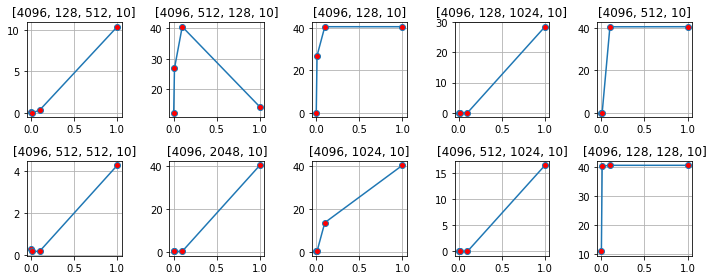

"\n# linear\nplt.subplot(2,2,1)\nc_nn='[4096, 128, 10]'\nm1=r.groupby('nn').get_group(c_nn)\nplt.plot(m1.lr, m1.loss,'-o', mfc='red')\nplt.title(c_nn)\nplt.grid(True)\n\n\n# log\nplt.subplot(222)\nplt.plot([1,2,3], [1,2,3])\n\nplt.grid(True)\n\n\n# symmetric log\nplt.subplot(223)\nplt.plot([1,2,3], [1,2,3])\n\nplt.grid(True)\n\n# logit\nplt.subplot(224)\nplt.plot([1,2,3], [1,2,3])\nplt.grid(True)\n\n"

In [77]:
import matplotlib.pyplot as plt
plt.figure(1,(10,4))
for index,nn in enumerate(r.groupby('nn').groups):
    plt.subplot(2,5,index+1)
    c_nn=str(nn)
    m1=r.groupby('nn').get_group(c_nn)
    plt.plot(m1.lr, m1.loss,'-o', mfc='red')
    plt.title(c_nn)
    plt.grid(True)
plt.tight_layout()

plt.show()



In [26]:
for nn in r.groupby('nn').groups:
    print r.groupby('nn').get_group(str(nn))

                      nn     lr       loss
20  [4096, 128, 512, 10]  0.001   0.121306
21  [4096, 128, 512, 10]  0.010   0.000005
22  [4096, 128, 512, 10]  0.100   0.333332
23  [4096, 128, 512, 10]  1.000  10.376253
                      nn     lr       loss
28  [4096, 512, 128, 10]  0.001  12.360544
29  [4096, 512, 128, 10]  0.010  26.899795
30  [4096, 512, 128, 10]  0.100  40.494896
31  [4096, 512, 128, 10]  1.000  14.333116
                nn     lr       loss
0  [4096, 128, 10]  0.001   0.135536
1  [4096, 128, 10]  0.010  26.874850
2  [4096, 128, 10]  0.100  40.494930
3  [4096, 128, 10]  1.000  40.499583
                       nn     lr          loss
24  [4096, 128, 1024, 10]  0.001  5.776423e-05
25  [4096, 128, 1024, 10]  0.010  2.213244e-13
26  [4096, 128, 1024, 10]  0.100  2.066818e-10
27  [4096, 128, 1024, 10]  1.000  2.849966e+01
                nn     lr       loss
4  [4096, 512, 10]  0.001   0.142274
5  [4096, 512, 10]  0.010   0.216725
6  [4096, 512, 10]  0.100  40.464496
7 

In [12]:
r.groupby('lr').get_group(0.01).values

array([['[4096, 128, 10]', 0.01, 26.874850207638772],
       ['[4096, 512, 10]', 0.01, 0.21672540728369566],
       ['[4096, 1024, 10]', 0.01, 0.2841949474052728],
       ['[4096, 2048, 10]', 0.01, 0.31257279024200785],
       ['[4096, 128, 128, 10]', 0.01, 40.226515668608094],
       ['[4096, 128, 512, 10]', 0.01, 5.024346128435502e-06],
       ['[4096, 128, 1024, 10]', 0.01, 2.2132435050358262e-13],
       ['[4096, 512, 128, 10]', 0.01, 26.89979455227707],
       ['[4096, 512, 512, 10]', 0.01, 0.17307022456274088],
       ['[4096, 512, 1024, 10]', 0.01, 1.5397547232383618e-09]],
      dtype=object)

In [ ]:
#load in real test data
print 'load in real test set...'
test_x=np.array(load_npz(test_x_path).todense())
result=[]
print 'test_x:',test_x.shape
for index, x in enumerate(test_x):
    predict_y=n.predict(x)
    result.append([index,predict_y])
result_df = pd.DataFrame(result)
result_df.columns =['Id','Label']
result_df.to_csv("test_y_predict.csv",header=True,index=False)